In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fa202939b0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
inspector = inspect(engine)

columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fa202cfd68>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
# Find the most recent date in the data set.
max_val = session.query(func.max(Measurement.date)).first()

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
first_date = datetime.datetime.strptime(max_val[0], "%Y-%m-%d").date()

print(first_date)
print(type(first_date))

2017-08-23
<class 'datetime.date'>


In [14]:
# Calculate the date one year from the last date in data set.
last_date = first_date - pd.DateOffset(years=1)
last_date = (last_date).date()
print(last_date)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
annual_precip = session.query(Measurement.date, Measurement.prcp, Measurement.station).\
                            filter(Measurement.date >= last_date).statement

In [16]:
# Save the query results as a Pandas DataFrame 
precip_df = pd.read_sql_query(annual_precip, session.bind)

In [17]:
# Sort the dataframe by date and set the index to the date column
precip_df = precip_df.sort_values("date", ascending=True)
precip_df

,date,prcp,station
0,2016-08-23,0.00,USC00519397
1009,2016-08-23,NaN,USC00517948
1529,2016-08-23,1.79,USC00519281
704,2016-08-23,0.05,USC00514830
361,2016-08-23,0.15,USC00513117
...,...,...,...
1527,2017-08-22,0.00,USC00519523
1008,2017-08-23,0.00,USC00514830
360,2017-08-23,0.00,USC00519397
1528,2017-08-23,0.08,USC00519523


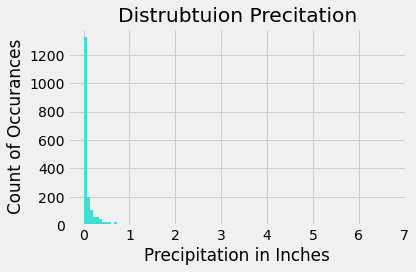

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_chart = precip_df.hist(column="prcp", bins=100, color="turquoise")
plt.xlabel("Precipitation in Inches")
plt.title("Distrubtuion Precitation")
plt.ylabel("Count of Occurances")

plt.tight_layout()
plt.show()

In [19]:
precip_df["date"] = pd.to_datetime(precip_df["date"])
precip_df["month"] = pd.DatetimeIndex(precip_df["date"]).month

precip_df#.dtypes

,date,prcp,station,month
0,2016-08-23,0.00,USC00519397,8
1009,2016-08-23,NaN,USC00517948,8
1529,2016-08-23,1.79,USC00519281,8
704,2016-08-23,0.05,USC00514830,8
361,2016-08-23,0.15,USC00513117,8
...,...,...,...,...
1527,2017-08-22,0.00,USC00519523,8
1008,2017-08-23,0.00,USC00514830,8
360,2017-08-23,0.00,USC00519397,8
1528,2017-08-23,0.08,USC00519523,8


In [20]:
avg_precip = precip_df.groupby("month").mean()
avg_precip

,prcp
month,
1,0.070294
2,0.241111
3,0.175266
4,0.321111
5,0.151317
6,0.120000
7,0.134773
8,0.193955
9,0.285549


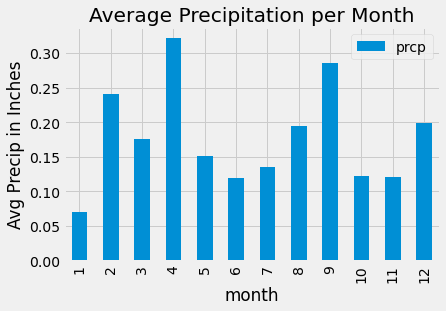

In [21]:
avg_precip_chart = avg_precip.plot(kind="bar", title="Average Precipitation per Month")
avg_precip_chart.set_ylabel("Avg Precip in Inches")
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp,month
count,2021.000000,2230.000000
mean,0.177279,6.539013
std,0.461190,3.487857
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.020000,7.000000
75%,0.130000,10.000000
max,6.700000,12.000000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
print(f'There are {total_stations} unique stations in this dataset')

There are 9 unique stations in this dataset


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station).order_by(Measurement.station.desc()).all()

station_activity = sorted(station_activity, key=lambda x:x[1], reverse=True)
station_activity

# https://stackoverflow.com/questions/10695139/sort-a-list-of-tuples-by-2nd-item-integer-value
# Accessed 18 March 2021

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = station_activity[0][0]
# print(station_id)

# most_activity = session.query(Measurement.date, Measurement.prcp, Measurement.tobs, Measurement.station).\
#                             filter(Measurement.station == station_id).all()
most_activity = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                            filter(Measurement.station == station_id).all()

print(f"The minimum temperature for station {station_id} is {most_activity[0][0]} deg F.")
print(f"The maxium temperature for station {station_id} is {most_activity[0][1]} deg F.")
print(f"The average temperature for station {station_id} is {round(most_activity[0][2],1)} deg F.")

The minimum temperature for station USC00519281 is 54.0 deg F.
The maxium temperature for station USC00519281 is 85.0 deg F.
The average temperature for station USC00519281 is 71.7 deg F.


In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_activity_twelve_months = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
                            filter(Measurement.date >= last_date).\
                            filter(Measurement.station == station_id).statement

In [27]:
station_activity_df = pd.read_sql_query(station_activity_twelve_months, session.bind)
station_activity_df

,date,tobs,station
0,2016-08-23,77.0,USC00519281
1,2016-08-24,77.0,USC00519281
2,2016-08-25,80.0,USC00519281
3,2016-08-26,80.0,USC00519281
4,2016-08-27,75.0,USC00519281
...,...,...,...
347,2017-08-14,77.0,USC00519281
348,2017-08-15,77.0,USC00519281
349,2017-08-16,76.0,USC00519281
350,2017-08-17,76.0,USC00519281


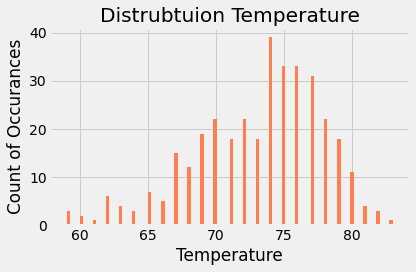

In [30]:
station_precip_chart = station_activity_df.hist(column="tobs", bins=100, color="coral")
plt.xlabel("Temperature")
plt.title("Distrubtuion Temperature")
plt.ylabel("Count of Occurances")

plt.tight_layout()
plt.show()

# Close session

In [ ]:
# Close Session
session.close()